<a href="https://colab.research.google.com/github/nullvoid-ky/introduction-to-machine-learning-and-deep-learning/blob/main/DATA_CLEAN%26AUGMENT_Run_Separate_Cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bankruptcy Prediction – Run models separately (per-cell)

**แนวคิด:** รันแต่ละโมเดลแยก cell เพื่อช่วยดีบัก/ควบคุมหน่วยความจำได้ง่ายขึ้น และใช้ **train/test split ร่วมกัน**

ลำดับรันแนะนำ:
1) Load `df` (หรือข้ามถ้าคุณมี `df` อยู่แล้ว)
2) Feature selection (X,y) + map target (alive→0, failed→1)
3) Import & class definitions
4) สร้าง Controller
5) **Split & Share** (เตรียม `shared_split`)
6) รันแต่ละโมเดล (LogReg / DT / RF / NB / SVM / Perceptron / MLP / PCA+RF / PCA+SVM / KMeans / Agglo)
7) Benchmark table, ROC curves, Loss curve


In [1]:
# ===== Setup & Installs (Kaggle usually has most of these; safe to re-run) =====
!pip -q install kagglehub shap lightgbm xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance

import shap
import warnings
warnings.filterwarnings('ignore')


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("utkarshx27/american-companies-bankruptcy-prediction-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.47M/4.47M [00:00<00:00, 95.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/versions/3


In [3]:
from kagglehub import KaggleDatasetAdapter, load_dataset

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Set the CSV file path **inside** the dataset (adjust if needed)
# Explore the dataset directory printed below to confirm the file name.
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
file_path = "/root/.cache/kagglehub/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/versions/3/american_bankruptcy.csv"

df = pd.read_csv(file_path)

print("Loaded shape:", df.shape)
print("Columns:\n", list(df.columns))
df.head()

Loaded shape: (78682, 21)
Columns:
 ['company_name', 'status_label', 'year', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']


,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [4]:

FEATURES = ["X8","X17","X3","X11","X10","X1","X6"]
TARGET   = "status_label"
COMPANY  = "company_name"   # ถ้าไม่มีคอลัมน์นี้ โค้ดจะ fallback อัตโนมัติ

# ---------- helpers ----------
def _check_cols(df, features, target, company_col=None):
    req = set(features+[target])
    miss = list(req - set(df.columns))
    if miss:
        raise ValueError(f"Missing columns: {miss}")
    if company_col is not None and company_col not in df.columns:
        company_col = None
    return company_col

def _clip_like(df_aug, df_ref, features):
    # คลิปค่าให้อยู่ในช่วง min/max ของทั้ง dataset เพื่อไม่ให้ synthetic หลุดโลก
    mins = df_ref[features].min()
    maxs = df_ref[features].max()
    df_aug[features] = df_aug[features].clip(lower=mins, upper=maxs, axis=1)
    return df_aug

def augment_failed(df, features=FEATURES, target=TARGET, company_col=COMPANY,
                   n_new=0, random_state=42):
    """สร้างแถว failed (target=1) เพิ่ม n_new แถว ด้วย 3 วิธี: uniform jitter, gaussian noise, mixup."""
    if n_new <= 0:
        return pd.DataFrame(columns=df.columns)

    rng = np.random.default_rng(random_state)
    df1 = df[df[target]==1].copy()
    if df1.empty:
        raise ValueError("No failed rows to augment.")

    # เตรียมสัดส่วน 3 วิธี แบ่งพอๆ กัน
    n1 = int(np.floor(n_new/3))
    n2 = int(np.floor(n_new/3))
    n3 = n_new - n1 - n2

    # 1) Uniform jitter ±0.5%
    take1 = df1.sample(n=max(n1,0), replace=True, random_state=random_state).copy()
    if not take1.empty:
        jitter = rng.uniform(-0.005, 0.005, size=(len(take1), len(features)))
        take1.loc[:, features] = take1[features].values * (1.0 + jitter)
        take1["aug_method"] = "uniform_0p5pct"

    # 2) Gaussian noise (σ = 0.5% ของ std ต่อคอลัมน์คลาส failed)
    take2 = df1.sample(n=max(n2,0), replace=True, random_state=random_state+1).copy()
    if not take2.empty:
        stds = df1[features].std().replace(0, 1e-12)
        noise = rng.normal(loc=0.0, scale=(0.005*stds.values), size=(len(take2), len(features)))
        take2.loc[:, features] = take2[features].values + noise
        take2["aug_method"] = "gaussian_0p5pct_std"

    # 3) Mixup (λ ~ Beta(0.4, 0.4))
    take3 = pd.DataFrame(columns=df.columns)
    if n3 > 0:
        a = df1.sample(n=n3, replace=True, random_state=random_state+2)
        b = df1.sample(n=n3, replace=True, random_state=random_state+3)
        lam = rng.beta(0.4, 0.4, size=n3).reshape(-1,1)
        mix_vals = lam * a[features].values + (1-lam) * b[features].values
        take3 = a.copy()
        take3.loc[:, features] = mix_vals
        take3["aug_method"] = "mixup_beta_0.4"

    df_aug = pd.concat([x for x in [take1, take2, take3] if not x.empty], ignore_index=True)
    df_aug[target] = 1

    # ทำให้ค่ามีเหตุผล (clip ตาม min/max ทั้ง df)
    df_aug = _clip_like(df_aug, df, features)

    # ถ้าอยากตั้งชื่อบริษัทให้รู้ว่าเป็น aug (เฉพาะมี company_name)
    if company_col is not None:
        df_aug[company_col] = df_aug[company_col].astype(str)  # คงบริษัทเดิมไว้ (สมจริงกว่า)
        # หรือจะเติม suffix:
        # df_aug[company_col] = df_aug[company_col].astype(str) + "_aug"

    return df_aug

def downsample_alive_diverse(df, keep_n, features=FEATURES, target=TARGET, company_col=COMPANY, random_state=42):
    """คัด 'alive'=0 ให้เหลือ keep_n โดยกระจาย 'บริษัท' ให้หลากหลายที่สุดเท่าที่ทำได้"""
    df0 = df[df[target]==0].copy()
    if company_col is None:
        # ไม่มี company_name → สุ่มตรงๆ
        return df0.sample(n=min(keep_n, len(df0)), replace=False, random_state=rs)

    rs = np.random.RandomState(random_state)

    # 1) เลือกอย่างน้อย 1 แถวต่่อบริษัท (ครอบคลุมบริษัทให้เยอะสุด)
    pick1 = df0.groupby(company_col, group_keys=False).apply(lambda g: g.sample(1, random_state=rs)).reset_index(drop=True)
    if len(pick1) >= keep_n:
        # บริษัทเยอะกว่าโควต้า → สุ่มเลือกบริษัทบางส่วน
        # เลือกบริษัทสุ่ม keep_n แห่ง แล้วหยิบ 1 แถวจากแต่ละบริษัท
        chosen_companies = rs.choice(pick1[company_col].unique(), size=keep_n, replace=False)
        kept = pick1[pick1[company_col].isin(chosen_companies)].copy()
        return kept.reset_index(drop=True)

    # 2) ถ้ายังไม่พอ ต้องเติมจากแถวนอกเหนือจากที่เลือกไปแล้ว
    rem_need = keep_n - len(pick1)
    remaining = df0.drop(index=pick1.index)
    if rem_need > len(remaining):
        rem_need = len(remaining)
    pick2 = remaining.sample(n=rem_need, replace=False, random_state=rs)
    kept = pd.concat([pick1, pick2], ignore_index=True)
    return kept.sample(frac=1.0, random_state=rs).reset_index(drop=True)

def balance_40_50(df, features=FEATURES, target=TARGET, company_col=COMPANY,
                  target_ratio=0.45, min_ratio=0.40, random_state=42):
    """
    ทำให้สัดส่วน failed อยู่ในช่วง ~40–50%.
    กลยุทธ์:
      1) คำนวณเพดานจำนวน alive ที่ 'ควรเก็บ' เพื่อให้ >= min_ratio โดยไม่ต้อง augment: N_new <= P*(1-min)/min
      2) downsample alive โดยกระจายบริษัท
      3) augment failed เพิ่มให้ถึง target_ratio ด้วย 3 วิธี noise
    """
    company_col = _check_cols(df, features, target, company_col)

    df = df.copy()
    df[target] = df[target].astype(int)

    P = int((df[target]==1).sum())
    N = int((df[target]==0).sum())

    if P == 0:
        raise ValueError("No failed rows in the dataset.")
    if N == 0:
        return df  # already all failed

    # 1) หาโควต้าจำนวน alive สูงสุดที่ยังทำให้ ratio >= min_ratio ถ้าไม่ augment
    #    เงื่อนไข: P / (P + N_keep) >= min_ratio  ->  N_keep <= P*(1-min)/min
    N_keep_cap = int(np.floor(P*(1 - min_ratio) / min_ratio))
    N_keep_cap = max(1, min(N_keep_cap, N))  # ป้องกันขอบ
    # เลือกจำนวน alive ที่เราจะ "เก็บ" จริง ๆ (อาจเท่ากับ cap)
    N_keep = N_keep_cap

    # 2) คัด alive ให้เหลือ N_keep โดยกระจายบริษัท
    kept_alive = downsample_alive_diverse(df, keep_n=N_keep, features=features, target=target,
                                          company_col=company_col, random_state=random_state)

    # 3) จำนวน failed ที่ "ต้องมี" เพื่อได้ target_ratio:
    #    r = (P + A) / (P + A + N_keep) = target_ratio  ->  A = r*N_keep/(1-r) - P
    A_need = int(np.ceil(target_ratio * N_keep / (1 - target_ratio) - P))
    A_need = max(0, A_need)

    df_failed = df[df[target]==1]
    df_aug = augment_failed(
        pd.concat([df_failed, kept_alive], ignore_index=True),  # ให้ clip ช่วงตามทั้งชุดใหม่
        features=features, target=target, company_col=company_col,
        n_new=A_need, random_state=random_state
    )

    # รวมชุดใหม่: failed เดิม + failed augment + alive ที่คัดไว้
    new_df = pd.concat([df_failed, df_aug, kept_alive], ignore_index=True)
    new_df = new_df.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

    # รายงานผล
    P2 = int((new_df[target]==1).sum()); N2 = int((new_df[target]==0).sum())
    ratio = P2 / (P2 + N2)
    print(f"Before: failed={P}, alive={N}, ratio={P/(P+N):.3f}")
    print(f"Keep alive = {N_keep}  |  Aug failed = {A_need}")
    print(f"After:  failed={P2}, alive={N2}, ratio={ratio:.3f}  (~{ratio*100:.1f}%)")
    if company_col is not None:
        uniq_alive = new_df.loc[new_df[target]==0, company_col].nunique()
        print(f"Unique companies among KEPT alive: {uniq_alive}")
    return new_df

In [8]:

# 0) ตรวจว่าคอลัมน์ครบไหม
missing = [c for c in FEATURES+[TARGET] if c not in df.columns]
if missing:
    raise ValueError(f"❌ Missing columns: {missing}")

# 1) ฟังก์ชัน normalize label ให้เป็น 0/1 แบบทนทาน
def normalize_status(x):
    if pd.isna(x):
        return np.nan
    t = str(x).strip().lower()
    # ตัวเลขที่มาเป็นสตริง หรือ float 0.0/1.0
    if t in {"0","1"}:
        return int(t)
    try:
        # กรณีเป็น 0.0/1.0 จริง ๆ
        f = float(t)
        if f in (0.0, 1.0):
            return int(f)
    except:
        pass
    # แม็พคำยอดฮิต
    direct = {
        "alive": 0, "non-bankrupt": 0, "nonbankrupt": 0, "healthy": 0, "normal": 0,
        "failed": 1, "fail": 1, "bankrupt": 1, "bankruptcy": 1, "went_bankrupt": 1,
        "yes": 1, "y": 1, "true": 1,
        "no": 0, "n": 0, "false": 0
    }
    if t in direct:
        return direct[t]
    # สุดท้าย ถ้าระบุไม่ถูก ให้คืน NaN เพื่อตรวจสอบ
    return np.nan

y_norm = df[TARGET].apply(normalize_status)

# 2) เช็คค่าที่แปลงไม่ได้ (จะเป็น NaN)
bad_mask = y_norm.isna()
if bad_mask.any():
    print("⚠️ พบ label ที่ไม่รู้จัก (ตัวอย่าง top 20):")
    print(df.loc[bad_mask, TARGET].value_counts().head(20))
    # ทางเลือก: ตัดแถวที่ label ไม่ชัดเจนทิ้งไปก่อน
    df = df.loc[~bad_mask].copy()
    y_norm = y_norm.loc[~bad_mask]

# 3) เขียนกลับเป็นตัวเลข 0/1
df[TARGET] = y_norm.astype(int)


balanced = balance_40_50(
    df=df,
    features=["X8","X17","X3","X11","X10","X1","X6"],
    target="status_label",
    company_col="company_name",   # ถ้าไม่มีคอลัมน์นี้ ปล่อยไว้หรือส่ง None
    target_ratio=0.5,            # ปรับเป็น 0.50 หากอยาก 50/50
    min_ratio=0.40,
    random_state=42
)

Before: failed=7830, alive=7830, ratio=0.500
Keep alive = 7830  |  Aug failed = 0
After:  failed=7830, alive=7830, ratio=0.500  (~50.0%)
Unique companies among KEPT alive: 7830


In [9]:
df = balanced.copy()
df.head()

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X10,X11,X12,X13,X14,X15,X16,X17,X18,aug_method
0,C_5076,1,2007,144.272,196.440,24.762,103.081,53.987,53.870,68.950,...,453.123,0.000,78.319,143.911,33.264,280.508,340.351,63.684,237.270,NaN
1,C_3382,1,2007,696.077,468.704,275.773,187.705,38.240,-35.337,112.843,...,1084.320,0.000,-88.068,561.763,299.572,271.212,1030.467,343.751,842.762,NaN
2,C_1173,1,2003,2243.311,9380.698,1281.690,2926.349,421.022,465.133,1505.500,...,32909.948,9789.066,1644.659,2926.349,4472.167,1251.736,12307.047,24285.484,9380.698,NaN
3,C_2470,1,1999,3154.200,10895.300,340.900,1049.800,577.300,257.100,2171.000,...,8717.600,3324.800,708.900,1533.500,3487.400,628.000,12428.800,7252.300,11379.000,NaN
4,C_5625,0,1999,505.900,1608.200,21.200,137.200,350.500,39.800,128.900,...,1049.300,434.700,116.000,137.200,200.500,119.800,1745.400,669.900,1608.200,NaN


In [10]:
# ==============================
# Load your DataFrame (df)
# ==============================
try:
    df  # noqa: F821
    print("✅ Found existing `df`.")
except NameError:
    import pandas as pd
    print("ℹ️ No existing `df` found. Creating a tiny placeholder. Replace with your CSV load.")
    df = pd.DataFrame({
        "X8":[0.1,0.2,0.3,0.4],
        "X17":[1,2,3,4],
        "X3":[5,6,7,8],
        "X11":[0,1,0,1],
        "X15":[10,11,12,13],
        "X1":[2,3,4,5],
        "X6":[9,8,7,6],
        "status_label":["alive","failed","alive","failed"],
    })
print("df shape:", df.shape)


✅ Found existing `df`.
df shape: (15660, 22)


In [21]:
# ==============================
# Feature selection (X, y) + map target
# ==============================
import numpy as np
import pandas as pd

FEATURES = ["X8","X17","X3","X11","X15","X1","X6"]
TARGET   = "status_label"

missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
if missing:
    raise ValueError(f"❌ Missing columns in df: {missing}")

# Make sure the target column is integer type
df[TARGET] = df[TARGET].astype(int)

X = df[FEATURES].copy()
y = df[TARGET].copy()

print("✅ X,y ready.")
print("X shape:", X.shape, "| y counts:", dict(pd.Series(y).value_counts()))

✅ X,y ready.
X shape: (15660, 7) | y counts: {1: np.int64(7830), 0: np.int64(7830)}


In [22]:
# ==============================
# Imports
# ==============================
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, f1_score,
    precision_score, recall_score, roc_curve, auc
)

plt.style.use("ggplot")
RANDOM_STATE = 42


In [23]:
# ==============================
# Base & Subclass Models (OOP)
# ==============================
class BaseModel(ABC):
    def __init__(self, X: pd.DataFrame, y: pd.Series, model_params: dict = None, random_state: int = RANDOM_STATE):
        self.X = X
        self.y = y
        self.random_state = random_state
        self.model = None
        self.model_params = model_params if model_params is not None else {}
        self.X_train = None
        self.X_test  = None
        self.y_train = None
        self.y_test  = None
        self.scaler = StandardScaler()
        self.history = None
        self.is_fitted = False

    def split_data(self, test_size: float = 0.2, scale: bool = True):
        X_train_raw, X_test_raw, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=self.random_state, stratify=self.y
        )
        if scale:
            self.X_train = pd.DataFrame(self.scaler.fit_transform(X_train_raw), columns=X_train_raw.columns)
            self.X_test  = pd.DataFrame(self.scaler.transform(X_test_raw), columns=X_test_raw.columns)
        else:
            self.X_train = X_train_raw
            self.X_test  = X_test_raw

    @abstractmethod
    def build_model(self):
        pass

    def fit(self):
        if self.X_train is None:
            raise ValueError("Data not split. Call .split_data() first.")
        self.build_model()
        self.model.fit(self.X_train, self.y_train)
        self.is_fitted = True
        if hasattr(self.model, "loss_curve_"):
            self.history = {"loss_curve": self.model.loss_curve_}
        print(f"✅ {self.__class__.__name__} trained.")

    def evaluate(self):
        if isinstance(self.model, (KMeans, AgglomerativeClustering)):
            return {"Note": "Unsupervised Model: Use specific clustering metrics."}

        if self.y_test is None or not self.is_fitted:
            return {"Error": "Model not fitted or Test data not available."}

        y_pred = self.model.predict(self.X_test)
        results = {}
        if len(np.unique(self.y_test)) == 2:
            try:
                tn, fp, fn, tp = confusion_matrix(self.y_test, y_pred).ravel()
                sensitivity = tp / (tp + fn) if (tp + fn) else 0.0
                specificity = tn / (tn + fp) if (tn + fp) else 0.0
                results = {
                    "Loss (MLP only)": getattr(self.model, "loss_", "N/A"),
                    "Confusion Matrix": confusion_matrix(self.y_test, y_pred).tolist(),
                    "Accuracy": accuracy_score(self.y_test, y_pred),
                    "Precision": precision_score(self.y_test, y_pred, zero_division=0),
                    "Sensitivity (Recall)": sensitivity,
                    "Specificity (TNR)": specificity,
                    "F1-score": f1_score(self.y_test, y_pred, zero_division=0),
                    "ROC AUC": "N/A",
                }
                if hasattr(self.model, "predict_proba"):
                    y_proba = self.model.predict_proba(self.X_test)[:, 1]
                    results["ROC AUC"] = roc_auc_score(self.y_test, y_proba)
            except Exception as e:
                results = {"Error": f"Evaluation failed: {e}"}
        else:
            results = {"Accuracy": accuracy_score(self.y_test, y_pred)}
        return results

    def plot_roc(self, ax=None, label_prefix=""):
        if not hasattr(self.model, "predict_proba") or self.y_test is None:
            return
        y_proba = self.model.predict_proba(self.X_test)[:, 1]
        fpr, tpr, _ = roc_curve(self.y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        if ax is None:
            fig, ax = plt.subplots(1, 1)
        ax.plot(fpr, tpr, label=f"{label_prefix} (AUC = {roc_auc:.4f})")
        ax.plot([0, 1], [0, 1], "r--")

    def plot_performance_curve(self, ax=None, label_prefix=""):
        if hasattr(self.model, "loss_curve_") and self.model.loss_curve_ is not None:
            if ax is None:
                fig, ax = plt.subplots(1, 1)
            ax.plot(self.model.loss_curve_, label=f"{label_prefix} Loss")
            ax.set_title("Model Loss Curve")
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Loss")
            ax.legend()

class LogisticRegressionModel(BaseModel):
    def build_model(self):
        self.model = LogisticRegression(random_state=self.random_state, **self.model_params)

class DecisionTreeModel(BaseModel):
    def build_model(self):
        self.model = DecisionTreeClassifier(random_state=self.random_state, **self.model_params)

class RandomForestModel(BaseModel):
    def build_model(self):
        self.model = RandomForestClassifier(random_state=self.random_state, **self.model_params)

class NaiveBayesModel(BaseModel):
    def build_model(self):
        self.model = GaussianNB(**self.model_params)

class SupportVectorMachineModel(BaseModel):
    def build_model(self):
        self.model = SVC(random_state=self.random_state, probability=True, **self.model_params)

class PerceptronModel(BaseModel):
    def build_model(self):
        self.model = Perceptron(random_state=self.random_state, **self.model_params)

class MLPModel(BaseModel):
    def build_model(self):
        self.model = MLPClassifier(random_state=self.random_state, **self.model_params)

class KMeanClustering(BaseModel):
    def build_model(self):
        n_clusters = self.model_params.pop("n_clusters", 2)
        self.model = KMeans(n_clusters=n_clusters, random_state=self.random_state, n_init=10, **self.model_params)
    def fit(self):
        if self.X_train is None:
            raise ValueError("Data not split.")
        self.build_model()
        self.model.fit(self.X_train)
        self.is_fitted = True
        print(f"✅ {self.__class__.__name__} trained.")

class AgglomerativeClusteringModel(BaseModel):
    def build_model(self):
        n_clusters = self.model_params.pop("n_clusters", 2)
        self.model = AgglomerativeClustering(n_clusters=n_clusters, **self.model_params)
    def fit(self):
        if self.X_train is None:
            raise ValueError("Data not split.")
        self.build_model()
        self.model.fit(self.X_train)
        self.is_fitted = True
        print(f"✅ {self.__class__.__name__} trained.")

class ReducedClassifierModel(BaseModel):
    def __init__(self, X, y, classifier_class, n_components, model_params=None, random_state=RANDOM_STATE):
        super().__init__(X, y, model_params, random_state)
        self.classifier_class = classifier_class
        self.n_components = n_components
    def build_model(self):
        pca = PCA(n_components=self.n_components, random_state=self.random_state)
        if self.classifier_class == SVC:
            classifier = SVC(random_state=self.random_state, probability=True, **self.model_params)
        else:
            classifier = self.classifier_class(random_state=self.random_state, **self.model_params)
        self.model = Pipeline(steps=[("pca", pca), ("classifier", classifier)])


In [24]:
# ==============================
# Controller (no run_all)
# ==============================
class ModelController:
    def __init__(self, X: pd.DataFrame, y: pd.Series, test_size: float = 0.2, random_state: int = RANDOM_STATE):
        self.X = X
        self.y = y
        self.test_size = test_size
        self.random_state = random_state
        self.models = self._initialize_models()
        self.results = {}

    def _initialize_models(self):
        svm_params  = {"C": 10, "gamma": "auto", "class_weight": "balanced"}
        rf_params   = {"n_estimators": 150, "class_weight": "balanced_subsample"}
        lr_params   = {"class_weight": "balanced"}
        dt_params   = {"class_weight": "balanced"}
        perc_params = {"class_weight": "balanced"}
        mlp_params  = {"hidden_layer_sizes": (50,), "max_iter": 500}

        return {
            "Logistic Regression": LogisticRegressionModel(self.X, self.y, model_params=lr_params),
            "Decision Tree": DecisionTreeModel(self.X, self.y, model_params=dt_params),
            "Random Forest": RandomForestModel(self.X, self.y, model_params=rf_params),
            "Naïve Bayesian": NaiveBayesModel(self.X, self.y),
            "Support Vector Machine": SupportVectorMachineModel(self.X, self.y, model_params=svm_params),
            "Perceptron (SLP)": PerceptronModel(self.X, self.y, model_params=perc_params),
            "Multi-layer Perceptron (MLP)": MLPModel(self.X, self.y, model_params=mlp_params),
            "PCA(5) + RF": ReducedClassifierModel(self.X, self.y, RandomForestClassifier, n_components=5, model_params=rf_params),
            "PCA(5) + SVM": ReducedClassifierModel(self.X, self.y, SVC, n_components=5, model_params=svm_params),
            "K-Means Clustering (k=2)": KMeanClustering(self.X, self.y, model_params={"n_clusters": 2}),
            "Agglomerative Clustering (k=2)": AgglomerativeClusteringModel(self.X, self.y, model_params={"n_clusters": 2}),
        }

    def get_results(self, model_name: str = None):
        if model_name:
            return self.results.get(model_name, "Model not found or not run.")
        return self.results

    def show_benchmarking(self):
        classification = {k: v for k, v in self.results.items()
                          if isinstance(v, dict) and ('Accuracy' in v or 'ROC AUC' in v)}
        if not classification:
            print("\n⚠️ No classification results to show benchmarking.")
            return
        df_results = pd.DataFrame.from_dict(classification, orient="index")
        metrics_order = ["Accuracy", "ROC AUC", "F1-score", "Precision", "Sensitivity (Recall)", "Specificity (TNR)"]
        cols = [m for m in metrics_order if m in df_results.columns]

        print("\n" + "="*70)
        print("📊 QUANTITATIVE BENCHMARKING RESULTS (Classification Models)")
        print("="*70)
        print(df_results[cols].sort_values(by="Accuracy", ascending=False).to_string(float_format="{:.4f}".format))
        print("\n* ROC AUC may be 'N/A' for models without predict_proba.")

    def plot_all_roc(self):
        plt.figure(figsize=(12, 8))
        ax = plt.gca()
        plotted = False
        for name, m in self.models.items():
            res = self.results.get(name, {})
            if isinstance(m, (KMeanClustering, AgglomerativeClusteringModel)):
                continue
            if res.get("ROC AUC") in ("N/A", None):
                continue
            try:
                m.plot_roc(ax=ax, label_prefix=name)
                plotted = True
            except Exception:
                pass
        if plotted:
            ax.set_title("Receiver Operating Characteristic (ROC) Curve Comparison", fontsize=16)
            ax.set_xlabel("False Positive Rate (1 - Specificity)")
            ax.set_ylabel("True Positive Rate (Sensitivity)")
            ax.legend(loc="lower right")
            plt.show()
        else:
            print("\n⚠️ No ROC Curves available for comparison.")

    def plot_loss_curves(self):
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
        found = False
        for name, m in self.models.items():
            if isinstance(m, MLPModel) and hasattr(m.model, "loss_curve_") and m.model.loss_curve_ is not None:
                m.plot_performance_curve(ax=ax, label_prefix=name)
                found = True
        if found:
            ax.set_title("Performance Curve: MLP Loss vs. Epochs", fontsize=16)
            plt.show()
        else:
            print("\n⚠️ No performance (loss) curves found for plotting.")


In [25]:
# ==============================
# Initialize controller
# ==============================
controller = ModelController(X=X, y=y, test_size=0.2, random_state=RANDOM_STATE)
list(controller.models.keys())


['Logistic Regression',
 'Decision Tree',
 'Random Forest',
 'Naïve Bayesian',
 'Support Vector Machine',
 'Perceptron (SLP)',
 'Multi-layer Perceptron (MLP)',
 'PCA(5) + RF',
 'PCA(5) + SVM',
 'K-Means Clustering (k=2)',
 'Agglomerative Clustering (k=2)']

In [26]:
# ==============================
# Split once & share
# ==============================
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    controller.X, controller.y, test_size=controller.test_size,
    random_state=controller.random_state, stratify=controller.y
)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_test  = pd.DataFrame(scaler.transform(X_test_raw), columns=X_test_raw.columns)
shared_split = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
print("✅ Split ready. Train:", X_train.shape, " Test:", X_test.shape)


✅ Split ready. Train: (12528, 7)  Test: (3132, 7)


In [27]:
# --- Logistic Regression ---
name = "Logistic Regression"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ LogisticRegressionModel trained.
Logistic Regression results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[568, 998], [338, 1228]], 'Accuracy': 0.5734355044699873, 'Precision': 0.5516621743036837, 'Sensitivity (Recall)': np.float64(0.7841634738186463), 'Specificity (TNR)': np.float64(0.36270753512132825), 'F1-score': 0.6476793248945147, 'ROC AUC': np.float64(0.6243269737346454)}


In [28]:
# --- Decision Tree ---
name = "Decision Tree"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ DecisionTreeModel trained.
Decision Tree results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[962, 604], [474, 1092]], 'Accuracy': 0.6558109833971902, 'Precision': 0.6438679245283019, 'Sensitivity (Recall)': np.float64(0.6973180076628352), 'Specificity (TNR)': np.float64(0.6143039591315453), 'F1-score': 0.6695278969957081, 'ROC AUC': np.float64(0.6558109833971902)}


In [29]:
# --- Random Forest ---
name = "Random Forest"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ RandomForestModel trained.
Random Forest results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[1120, 446], [390, 1176]], 'Accuracy': 0.7330779054916986, 'Precision': 0.7250308261405672, 'Sensitivity (Recall)': np.float64(0.7509578544061303), 'Specificity (TNR)': np.float64(0.7151979565772669), 'F1-score': 0.7377666248431619, 'ROC AUC': np.float64(0.8210316936040281)}


In [30]:
# --- Naïve Bayesian ---
name = "Naïve Bayesian"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ NaiveBayesModel trained.
Naïve Bayesian results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[104, 1462], [79, 1487]], 'Accuracy': 0.5079821200510856, 'Precision': 0.5042387249915226, 'Sensitivity (Recall)': np.float64(0.9495530012771393), 'Specificity (TNR)': np.float64(0.06641123882503193), 'F1-score': 0.6586932447397563, 'ROC AUC': np.float64(0.5529286938764193)}


In [31]:
# --- Support Vector Machine ---
name = "Support Vector Machine"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ SupportVectorMachineModel trained.
Support Vector Machine results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[1390, 176], [1153, 413]], 'Accuracy': 0.5756704980842912, 'Precision': 0.7011884550084889, 'Sensitivity (Recall)': np.float64(0.26372924648786716), 'Specificity (TNR)': np.float64(0.8876117496807152), 'F1-score': 0.38329466357308584, 'ROC AUC': np.float64(0.6494114231375869)}


In [32]:
# --- Perceptron (SLP) ---
name = "Perceptron (SLP)"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ PerceptronModel trained.
Perceptron (SLP) results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[523, 1043], [475, 1091]], 'Accuracy': 0.5153256704980843, 'Precision': 0.5112464854732895, 'Sensitivity (Recall)': np.float64(0.6966794380587484), 'Specificity (TNR)': np.float64(0.3339719029374202), 'F1-score': 0.5897297297297297, 'ROC AUC': 'N/A'}


In [33]:
# --- Multi-layer Perceptron (MLP) ---
name = "Multi-layer Perceptron (MLP)"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ MLPModel trained.
Multi-layer Perceptron (MLP) results: {'Loss (MLP only)': np.float64(0.6306314872120103), 'Confusion Matrix': [[1132, 434], [742, 824]], 'Accuracy': 0.6245210727969349, 'Precision': 0.6550079491255962, 'Sensitivity (Recall)': np.float64(0.5261813537675607), 'Specificity (TNR)': np.float64(0.722860791826309), 'F1-score': 0.5835694050991501, 'ROC AUC': np.float64(0.6748775463268791)}


In [34]:
# --- PCA(5) + RF ---
name = "PCA(5) + RF"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ ReducedClassifierModel trained.
PCA(5) + RF results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[1082, 484], [447, 1119]], 'Accuracy': 0.7027458492975734, 'Precision': 0.6980661260137243, 'Sensitivity (Recall)': np.float64(0.7145593869731801), 'Specificity (TNR)': np.float64(0.6909323116219668), 'F1-score': 0.7062164720732093, 'ROC AUC': np.float64(0.7828620722276864)}


In [35]:
# --- PCA(5) + SVM ---
name = "PCA(5) + SVM"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ ReducedClassifierModel trained.
PCA(5) + SVM results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[1382, 184], [1138, 428]], 'Accuracy': 0.5779054916985952, 'Precision': 0.6993464052287581, 'Sensitivity (Recall)': np.float64(0.27330779054916987), 'Specificity (TNR)': np.float64(0.8825031928480205), 'F1-score': 0.39302112029384756, 'ROC AUC': np.float64(0.6449096297601165)}


In [36]:
# --- K-Means Clustering (k=2) ---
name = "K-Means Clustering (k=2)"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ KMeanClustering trained.
K-Means Clustering (k=2) results: {'Note': 'Unsupervised Model: Use specific clustering metrics.'}


In [37]:
# --- Agglomerative Clustering (k=2) ---
name = "Agglomerative Clustering (k=2)"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ AgglomerativeClusteringModel trained.
Agglomerative Clustering (k=2) results: {'Note': 'Unsupervised Model: Use specific clustering metrics.'}


In [38]:
controller.show_benchmarking()


📊 QUANTITATIVE BENCHMARKING RESULTS (Classification Models)
                              Accuracy ROC AUC  F1-score  Precision  Sensitivity (Recall)  Specificity (TNR)
Random Forest                   0.7331  0.8210    0.7378     0.7250                0.7510             0.7152
PCA(5) + RF                     0.7027  0.7829    0.7062     0.6981                0.7146             0.6909
Decision Tree                   0.6558  0.6558    0.6695     0.6439                0.6973             0.6143
Multi-layer Perceptron (MLP)    0.6245  0.6749    0.5836     0.6550                0.5262             0.7229
PCA(5) + SVM                    0.5779  0.6449    0.3930     0.6993                0.2733             0.8825
Support Vector Machine          0.5757  0.6494    0.3833     0.7012                0.2637             0.8876
Logistic Regression             0.5734  0.6243    0.6477     0.5517                0.7842             0.3627
Perceptron (SLP)                0.5153     N/A    0.5897     0.5112

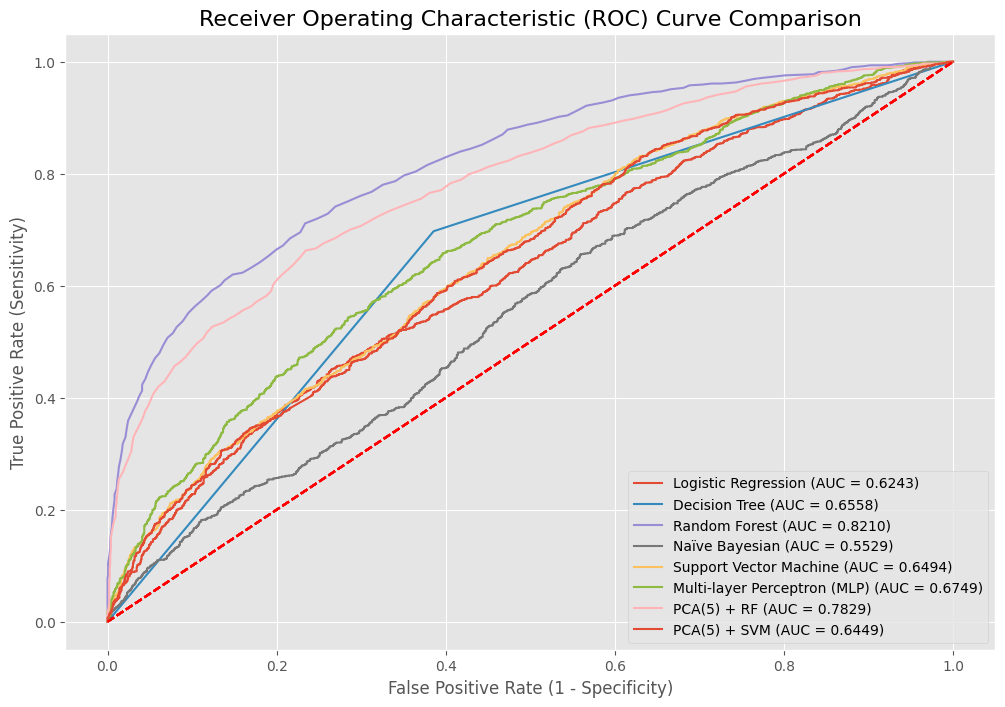

In [39]:
controller.plot_all_roc()

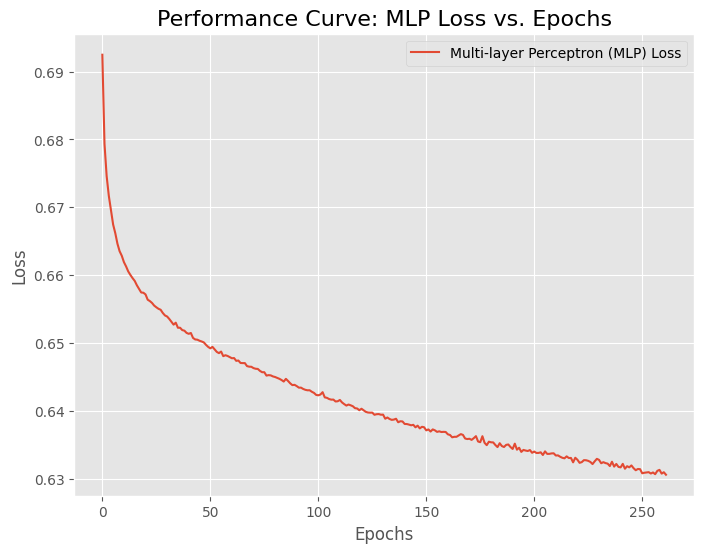

In [40]:
controller.plot_loss_curves()